<a href="https://colab.research.google.com/github/DanieleFoscarin/NNDL_hw2/blob/main/nndl_2020__homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 2 - Unsupervised Deep Learning

## General overview
In this homework you will learn how to implement and test neural network models for solving unsupervised problems. For simplicity and to allow continuity with the kind of data you have seen before, the homework will be based on images of handwritten digits (MNIST). However, you can optionally explore different image collections (e.g., [Caltech](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) or [Cifar](https://www.cs.toronto.edu/~kriz/cifar.html)) or other datasets based on your interests. The basic tasks for the homework will require to test and analyze the convolutional autoencoder implemented during the Lab practice. If you prefer, you can opt for a fully-connected autoencoder, which should achieve similar performance considering the relatively small size of the MNIST images. As for the previous homework, you should explore the use of advanced optimizers and regularization methods. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. More advanced tasks will require the exploration of denoising and variational architectures.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework. If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length must not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	1 pt: implement and test (convolutional) autoencoder, reporting the trend of reconstruction loss and some examples of image reconstruction
*	1 pt: explore advanced optimizers and regularization methods 
*	1 pt: optimize hyperparameters using grid/random search and cross-validation
*	1 pt: implement and test denoising (convolutional) autoencoder
*	1 pt: fine-tune the (convolutional) autoencoder using a supervised classification task (you can compare classification accuracy and learning speed with results achieved in homework 1)
*	1 pt: explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes
*	2 pt: implement variational (convolutional) autoencoder or GAN




## Deadline
The complete homework (source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.

#################################################################

In [37]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
from sklearn.decomposition import PCA

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms
import torchvision

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
torch.manual_seed(0)

Training device: cuda



# Dataset






get notMNIST dataset from repo
It is the small version

In [2]:
! git clone https://github.com/DanieleFoscarin/NNDL_hw2.git

Cloning into 'NNDL_hw2'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 63 (delta 25), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (63/63), done.


In [3]:
! tar xzf  /content/NNDL_hw2/notMNIST_small.tar.gz

In [4]:
ROOT = '/content/notMNIST_small' 
from pathlib import Path
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

images = []
labels = []

#there are few broken files that cannot be read
#not a big problem since they are 5 over 500k
num_label = 0
for folder in sorted(Path(ROOT).iterdir()):
  print(folder)
  for f in folder.iterdir():
    try:     
      img = Image.open(f)
      img_array = np.asarray(img)
      images.append(img_array)
      labels.append(num_label)
    except:
      print("a file was not recognized")
  num_label+=1


images_arr = np.float32(np.array(images))
labels_arr = np.float32(np.array(labels))

#normalize images range
images_arr = images_arr/255
#free up some memory
del images

# #split dataset for classification purposes if needed
# X_train, X_test, y_train, y_test = train_test_split(images_arr, labels_arr, test_size=0.10, random_state=42)

# print(np.shape(X_train),' ', np.shape(y_train),' ', np.shape(X_test),' ', np.shape(y_test))

/content/notMNIST_small/A
a file was not recognized
/content/notMNIST_small/B
/content/notMNIST_small/C
/content/notMNIST_small/D
/content/notMNIST_small/E
/content/notMNIST_small/F
a file was not recognized
/content/notMNIST_small/G
/content/notMNIST_small/H
/content/notMNIST_small/I
/content/notMNIST_small/J


Dictionary for easy interpreation of the labels

In [5]:
letter = {0: 'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'J'}
# print(letter[6])

In [6]:
### Set the random seed for reproducible results
torch.manual_seed(0)

In [7]:
#not sure the transformation is done correctly
class NMDataset(Dataset):

    def __init__(self, image, label, transform=None):
        self.transform = transform
        self.image = image
        self.label = label

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        #return a nparray from the dataframe
        this_image = self.image[idx]
        this_label = self.label[idx]
        sample = [this_image, this_label]
        if self.transform:
            sample[0] = self.transform(sample[0])
        return sample


    class ToTensor(object):
        """Convert sample to Tensors."""

        def __call__(self, sample):
            x, y = sample
            return (torch.tensor([x]).float(),
                    torch.tensor([y]).float())

to_tensor = torchvision.transforms.ToTensor()   
# composed_transform = transforms.Compose([ToTensor()])
dataset = NMDataset(images_arr, labels_arr, transform=to_tensor)

#check correctness
out = dataset.__getitem__(0)
print(labels_arr[0])


0.0


Split dataset in train, validation, test

In [8]:
length = dataset.__len__()
testval_size = int(np.ceil(length*0.4))
train_size = int(length-testval_size)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, testval_size])

test_size = int(np.ceil(test_dataset.__len__()*0.5))
val_size = int(test_dataset.__len__()-test_size)
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [test_size, val_size])

print(f"train_dataset length {train_dataset.__len__()}")
print(f"val_dataset length {val_dataset.__len__()}")
print(f"test_dataset length {test_dataset.__len__()}")
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_dataset length 11234
val_dataset length 3745
test_dataset length 3745


It works with mnist mmmmh

In [9]:
#just to check database functions
# to_tensor = torchvision.transforms.ToTensor()
# data_dir = 'dataset'
# train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=to_tensor)
# test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=to_tensor)

Show example of the dataset

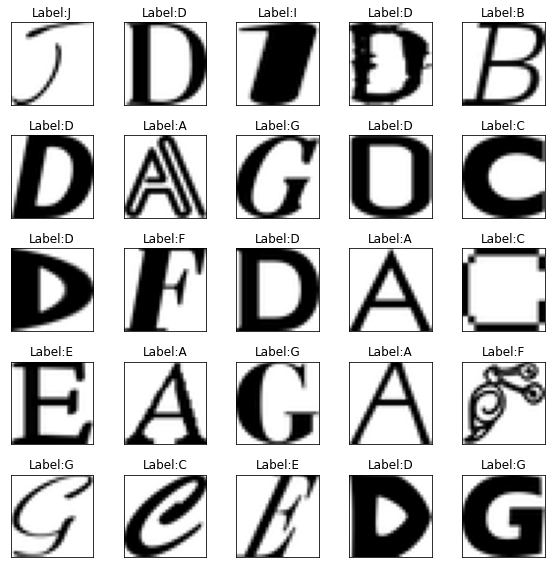

In [10]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(test_dataset)
    img = img.numpy().squeeze()
    ax.imshow(np.array(img), cmap='gray_r')
    ax.set_title(f'Label:{letter[label]}' )
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

# Autoencoder Model Classes

same as the lab for now

In [11]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(64, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [12]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

# Training preparation

need to make grid search here

function for a single epoch training

In [15]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
    
    return loss.data

function for a single epoch inference

In [16]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [17]:

# img, label = test_dataset[0]
# print(np.shape(img))
# print(letter[label])

# Training loop as function

In [31]:
### Initialize the two networks
encoded_space_dim = 3
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

NB: remember to reinitializer encoder and decoder before the training

In [18]:
def training_loop(encoder, decoder, device, loss_fn, optim, num_epochs, batch_size, display=False):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    #is it better to make the dataloader outside?

    train_loss_record = []
    val_loss_record = []

    for epoch in range(num_epochs):
        print('EPOCH %d/%d' % (epoch + 1, num_epochs))

        train_loss_batch_record = []
        val_loss_batch_record = []
        ### Training (use the training function)
        train_loss_batch = train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        train_loss_batch_record.append(train_loss_batch)
        ### Validation  (use the testing function)
        val_loss_batch = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=test_dataloader, 
            loss_fn=loss_fn)
        val_loss_batch_record.append(val_loss_batch)
        if display:
        # Print Validationloss
            print('\n\n\t TRAINING - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, 
                                                                    sum(train_loss_batch_record)/len(train_loss_batch_record)))
            print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss_batch))

        #store losses for this epoch
        train_loss_record.append(sum(train_loss_batch_record)/len(train_loss_batch_record))
        val_loss_record.append(sum(val_loss_batch_record)/len(val_loss_batch_record))

        if display:
            ### Plot progress
            # Get the output of a specific image (the test image at index 0 in this case)
            img = test_dataset[0][0].unsqueeze(0).to(device)
            encoder.eval()
            decoder.eval()
            with torch.no_grad():
                rec_img  = decoder(encoder(img))
            # Plot the reconstructed image
            fig, axs = plt.subplots(1, 2, figsize=(6,3))
            axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gray_r')
            axs[0].set_title('Original image')
            axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray_r')
            axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
            plt.tight_layout()
            plt.pause(0.1)
            # Save figures
            os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
            fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
            plt.show()
            plt.close()

    return encoder, decoder, train_loss_record, val_loss_record
    # # Save network parameters
    # torch.save(encoder.state_dict(), 'encoder_params.pth')
    # torch.save(decoder.state_dict(), 'decoder_params.pth')

    # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training

test training function

In [ ]:
_, _, train_loss_record, val_loss_record = training_loop(encoder,
                                                         decoder,
                                                         device,
                                                         loss_fn,
                                                         optim,
                                                         50,
                                                         512,
                                                         display=True)

plot losses

Text(0.5, 1.0, 'Losses')

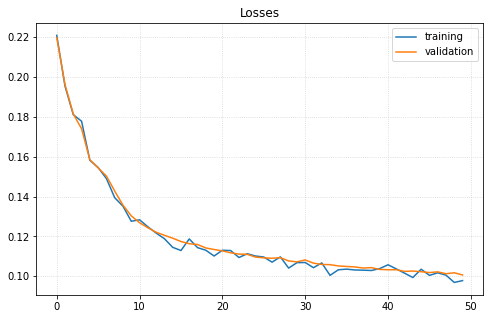

In [20]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(train_loss_record, label="training")
ax.plot(val_loss_record, label="validation")
ax.legend()
ax.grid(color="lightgray", linestyle=":")
ax.set_title("Losses")

# Latent space analysis

In [ ]:
# # Load network parameters
# encoder.load_state_dict(torch.load('encoder_params.pth'))
# decoder.load_state_dict(torch.load('decoder_params.pth'))

Function for generation of encoded samples

In [44]:
### Get the encoded representation of the test samples
def make_encoded_samples(dataset, encoder, device):
    encoded_samples = []
    for sample in tqdm(dataset):
        img = sample[0].unsqueeze(0).to(device)
        label = sample[1]
        # Encode image
        encoder.eval()
        with torch.no_grad():
            encoded_img  = encoder(img)
        # Append to list
        encoded_img = encoded_img.flatten().cpu().numpy()
        encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
        encoded_sample['label'] = label
        encoded_samples.append(encoded_sample)
    
    return encoded_samples

In [43]:
encoded_samples = make_encoded_samples(test_dataset, encoder, device)


100%|██████████| 3745/3745 [00:03<00:00, 1025.87it/s]


AttributeError: ignored

In [40]:
print(type(encoded_samples))
print(np.shape(encoded_samples))
print(encoded_samples[0])

<class 'list'>
(3745,)
{'Enc. Variable 0': 26.27268, 'Enc. Variable 1': -8.605742, 'Enc. Variable 2': -4.129607, 'label': 5.0}


In [45]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,label
0,26.272680,-8.605742,-4.129607,5.0
1,9.854316,-7.938509,4.087257,7.0
2,-2.771627,7.919210,11.015038,7.0
3,7.929948,-3.376163,15.113423,6.0
4,6.195666,2.282199,-3.589114,3.0
...,...,...,...,...
3740,17.286819,-2.934390,5.772316,2.0
3741,14.120298,-6.696294,1.478737,3.0
3742,12.322736,-9.912532,3.247149,7.0
3743,-12.506181,-18.154570,0.577705,9.0


In [47]:
arsamp = encoded_samples.iloc[:,0:encoded_space_dim]
arsamp

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2
0,26.272680,-8.605742,-4.129607
1,9.854316,-7.938509,4.087257
2,-2.771627,7.919210,11.015038
3,7.929948,-3.376163,15.113423
4,6.195666,2.282199,-3.589114
...,...,...,...
3740,17.286819,-2.934390,5.772316
3741,14.120298,-6.696294,1.478737
3742,12.322736,-9.912532,3.247149
3743,-12.506181,-18.154570,0.577705


## PCA if dim > 2

In [63]:
if encoded_space_dim > 2:
    PCAobj = PCA(n_components=2)
    PCAobj.fit(encoded_samples.iloc[:,0:encoded_space_dim])
    encoded_samples_reduced = PCAobj.transform(encoded_samples.iloc[:,0:encoded_space_dim])

    encoded_samples_reduced = pd.DataFrame(encoded_samples_reduced)
    # encoded_samples_reduced.insert(encoded_space_dim, "label", encoded_samples["label"], True)
    encoded_samples_reduced['label'] = encoded_samples['label']
    encoded_samples_reduced.columns = ['Enc. Variable 0', 'Enc. Variable 1', 'label']
    encoded_samples_reduced

    # print(PCAobj.explained_variance_ratio_)
    # print(type(encoded_samples_reduced))
    # print(np.shape(encoded_samples_reduced))
else:
    encoded_samples_reduced = encoded_samples
    

pca ok


In [64]:
encoded_samples_reduced

,Enc. Variable 0,Enc. Variable 1,label
0,-15.626076,-11.699442,5.0
1,-1.768767,-0.571064,7.0
2,7.011249,16.871989,7.0
3,-3.005149,11.202443,6.0
4,2.404859,-0.149234,3.0
...,...,...,...
3740,-9.905745,1.600435,2.0
3741,-5.418515,-3.064733,3.0
3742,-3.732862,-2.955115,7.0
3743,21.799449,-3.212740,9.0


This graph shows where each input image is mapped in the encoded space. Since we have just 2 encoded variables, we can easily plot them in a bidimensional space. 

In [65]:
import plotly.express as px
px.scatter(encoded_samples_reduced, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

As you can see from the graph, even if we never used the labels (i.e. the actual digit written in the image) during the training, the network has been able to clusterize quite well the different classes.

> **NOTE**
> 
> The encoded space may have many more variables. In this case you can still have a visual representation of the encoded space by applying a dimensionality reduction method, such as:
- [Princiapal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [t-distributed Stochastic Neighbor Embedding (t-SNE)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)




While the encoder is able to map the image to the encoded space, the decoder can do the opposite, generating an image given the corresponding latent space values.

The latent space can also be manually customized, like in the following example, where we generate images with the decoder by providing custom latent space variables.

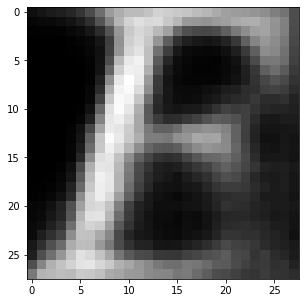

In [27]:
if encoded_space_dim == 2:
    # Generate a custom sample
    custom_encoded_sample = [-5, -10.0]
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

    # Decode sample
    decoder.eval()
    with torch.no_grad():
        generated_img  = decoder(encoded_value)

    plt.figure(figsize=(6,5))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gray_r')
    plt.show()